In [1]:
# Importing libraries

import numpy as np
from gudhi import SimplexTree
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Function for simplical complex

def construct_simplicial_complex(points, function_values, threshold):
    """
    Constructs a simplicial complex based on points and a filtration threshold.

    Parameters:
    - points: (N, 2) array of 2D points.
    - function_values: 1D array of function values for the points.
    - threshold: Filtration value to add simplices to the complex.

    Returns:
    - simplex_tree: Gudhi's SimplexTree with filtration values.
    """
    # Compute the Delaunay triangulation of the points
    delaunay = Delaunay(points)
    simplex_tree = SimplexTree()
    
    # Add vertices (0-simplices) with filtration values based on function values
    for i, value in enumerate(function_values):
        if value <= threshold:
            simplex_tree.insert([i], filtration=value)

    # Add edges, triangles, etc., from the Delaunay triangulation
    for simplex in delaunay.simplices:
        filtration_value = max(function_values[simplex])
        if filtration_value <= threshold:
            simplex_tree.insert(simplex, filtration=filtration_value)

    simplex_tree.initialize_filtration()
    return simplex_tree

In [3]:
# Function for computing bottleneck distance

def compute_bottleneck_distance(dgm1, dgm2):
    """
    Compute the bottleneck distance between two persistence diagrams.
    """
    # Add diagonal projections
    dgm1_with_diag = np.vstack([dgm1, np.c_[dgm1[:, 0], dgm1[:, 0]]])
    dgm2_with_diag = np.vstack([dgm2, np.c_[dgm2[:, 0], dgm2[:, 0]]])
    
    # Compute pairwise L_infinity distances
    pairwise_distances = cdist(dgm1_with_diag, dgm2_with_diag, metric="chebyshev")
    
    # Solve optimal matching
    row_ind, col_ind = linear_sum_assignment(pairwise_distances)
    return pairwise_distances[row_ind, col_ind].max()

In [4]:
# Define tame functions - f and g

# Define points on a 1D grid
x = np.linspace(0, 10, 100)
f = np.sin(x) + 0.5 * np.sin(3 * x) + 0.2 * np.sin(7 * x) + 2  # Complex tame function f
g = np.sin(x + 0.1) + 0.5 * np.sin(3 * x + 0.1) + 0.2 * np.sin(7 * x + 0.1) + 2  # Slightly perturbed g

In [5]:
# Compute L_infinity distance between f and g

l_inf_dist = np.max(np.abs(f - g))
l_inf_dist

0.16983633928099762

In [6]:
# Lift 1D points into 2D space for Delaunay triangulation
points_f = np.column_stack((x, f))
points_g = np.column_stack((x, g))

In [7]:
# Set a filtration threshold
threshold = max(np.max(f), np.max(g))  # Example: include all simplices
threshold

3.058255649298318

In [8]:
# Construct simplicial complexes for f and g
f_complex = construct_simplicial_complex(points_f, f, threshold)
g_complex = construct_simplicial_complex(points_g, g, threshold)

In [9]:
# Compute persistence diagrams
f_persistence = f_complex.persistence()
g_persistence = g_complex.persistence()

In [10]:
# Extract persistence diagrams for dimension 0
f_diag_points = np.array(f_complex.persistence_intervals_in_dimension(0))
g_diag_points = np.array(g_complex.persistence_intervals_in_dimension(0))

In [11]:
# Compute bottleneck distance
bottleneck_dist = compute_bottleneck_distance(f_diag_points, g_diag_points) if f_diag_points.size > 0 and g_diag_points.size > 0 else None
bottleneck_dist

0.09811278815612123

In [12]:
# Output Results
print("L∞ Distance:", l_inf_dist)
print("Bottleneck Distance:", bottleneck_dist)

L∞ Distance: 0.16983633928099762
Bottleneck Distance: 0.09811278815612123


In [13]:
# Verify Stability Theorem
if bottleneck_dist is not None:
    if bottleneck_dist <= l_inf_dist:
        print("Stability Theorem Verified: Bottleneck Distance <= L∞-Distance")
    else:
        print("Stability Theorem Not Verified")
else:
    print("Cannot verify Stability Theorem: One or both persistence diagrams are empty.")

Stability Theorem Verified: Bottleneck Distance <= L∞-Distance


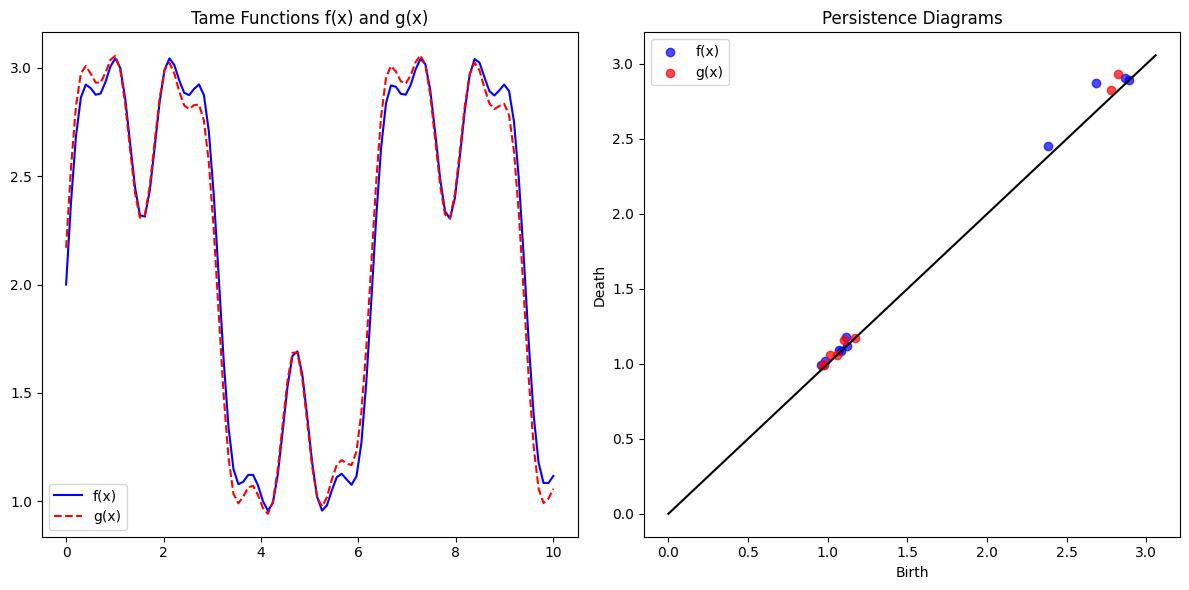

In [14]:
# Visualize tame functions
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(x, f, label="f(x)", color="blue")
plt.plot(x, g, label="g(x)", color="red", linestyle="dashed")
plt.title("Tame Functions f(x) and g(x)")
plt.legend()

# Visualize persistence diagrams
plt.subplot(1, 2, 2)
if f_diag_points.size > 0:
    plt.scatter(f_diag_points[:, 0], f_diag_points[:, 1], label="f(x)", color="blue", alpha=0.7)
if g_diag_points.size > 0:
    plt.scatter(g_diag_points[:, 0], g_diag_points[:, 1], label="g(x)", color="red", alpha=0.7)
plt.plot([0, max(f.max(), g.max())], [0, max(f.max(), g.max())], color="black")
plt.title("Persistence Diagrams")
plt.xlabel("Birth")
plt.ylabel("Death")
plt.legend()

plt.tight_layout()
plt.show()